#Homework 1
Done by staudent: Kirilin Anton
university mail: a.kirilin@innopolis.university


For this assignment I've decided to use the PUMA configuration for the robot arm. It's basically 3 revolute joint connected via normal (not T-shaped or whatever) links. The picture of the robot is below.

![Текст ссылки](https://www.researchgate.net/profile/Abdullah-Cakan/publication/311953769/figure/fig1/AS:444591880052736@1483010372754/PUMA-Robot-dimensions-and-joint-angles.png)

For the spherical wrist I've decided to use a YZY configuration (with respect to the base frame). However I'm using Denavit-Hartenberg(DH) method for constracting the frames of each joint and defining matrices of the Forward Kinematics (FK) of the robot. Therefore, the configuration is viable (the sperical wrist indeed can be described using Euler's angles on its' own), but it cannot be solved by the predefined formulas for the Inverse Kinematics (IK) of spherical wrist using Euler's angles. That is why I used symbolic approach to solve this problem.


Here's the configuration of the robot by DH method with all joints in the starting position($q_i$=0)


![](https://drive.google.com/uc?id=1ENvItAzfkZhuMaQ6XdjM6k8UOhNAnHC_)

Here is the explicit configuration of the frames for a better view

![](https://drive.google.com/uc?id=1ENRdflowz1fKTv8KG0JinC4R7_WHLD7m)

Finally calculated by hand parameters of DH and the respective matrix that creates the transition from i-1 frame to i

![](https://drive.google.com/uc?id=1EJ740LTG7u9R1WeMRX5R7hS4RqML2bj3)

Now let's code the Forward Kinematics for the robot

In [2]:
import numpy as np
import sympy as sp
from sympy.matrices import Matrix

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [4]:
def Rx(q):
    T = np.array([[1,         0,          0, 0],
                  [0, np.cos(q), -np.sin(q), 0],
                  [0, np.sin(q),  np.cos(q), 0],
                  [0,         0,          0, 1]], dtype=float)
    return T


def Ry(q):
    T = np.array([[ np.cos(q), 0, np.sin(q), 0],
                  [         0, 1,         0, 0],
                  [-np.sin(q), 0, np.cos(q), 0],
                  [         0, 0,         0, 1]], dtype=float)
    return T


def Rz(q):
    T = np.array([[np.cos(q), -np.sin(q), 0, 0],
                  [np.sin(q),  np.cos(q), 0, 0],
                  [        0,          0, 1, 0],
                  [        0,          0, 0, 1]], dtype=float)
    return T


def Tx(x):
    T = np.array([[1, 0, 0, x],
                  [0, 1, 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]], dtype=float)
    return T


def Ty(y):
    T = np.array([[1, 0, 0, 0],
                  [0, 1, 0, y],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]], dtype=float)
    return T


def Tz(z):
    T = np.array([[1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, z],
                  [0, 0, 0, 1]], dtype=float)
    return T

Here's the function for creating a transition matrix from (i-1)th joint to i-th joint

In [5]:
def DH(d, theta, a, alpha):
    A = Rz(theta) @ Tz(d) @ Tx(a) @ Rx(alpha)
    return A

Defining parameters from the DH table

In [6]:
# robot parameters, links (m)
l1 = 0.346
l2 = 0.324
l3 = 0.312
d6 = 0.2

In [7]:
d_p= np.array([l1, 0, 0, l3, 0, d6])
th_p = np.array([np.pi/2, 0, np.pi/2, np.pi/2, 0, 0])
a_p = np.array([0, l2, 0, 0, 0, 0])
al_p = np.array([np.pi/2, 0, np.pi/2, np.pi/2, -np.pi/2, 0])

Forward kinematics is simply multiplication of the matrices in a right order

In [8]:
def FK(q_cor):
    Matrix = np.eye(4)

    for i, q in enumerate(q_cor):
      Matrix = Matrix @ DH(d_p[i], th_p[i]+q, a_p[i], al_p[i])

    return Matrix


The same DH transitiom matrix but in a symbolic form. This function is used later for finding the angles of the spherical wrist

In [9]:
def sym_DH(d, theta, a, alpha):
  # returns the pose T of one joint frame i with respect to the previous joint frame (i - 1)
  # given the parameters:
  # theta: theta[i]
  # alpha: alpha[i-1]
  # a: a[i-1]
  # d: d[i]m

  r11, r21 = sp.cos(theta), sp.sin(theta)
  r32, r33 = sp.sin(alpha), sp.cos(alpha)
  r12 = -sp.sin(theta) * sp.cos(alpha)
  r22 = sp.cos(theta) * sp.cos(alpha)
  r13 = sp.sin(theta) * sp.sin(alpha)
  r23 = -sp.cos(theta) * sp.sin(alpha)
  x = a * sp.cos(theta)
  y = a * sp.sin(theta)

  T = Matrix([
    [r11, r12, r13, x],
    [r21, r22, r23, y],
    [0  , r32, r33, d],
    [0.0, 0.0, 0.0, 1]
  ])

  T = sp.simplify(T)

  return T

In [10]:
thetas = sp.symbols(r'\theta_4:7')
sl3 = sp.Symbol(r"l_3")
sd6 = sp.Symbol(r"d_6")

In [11]:
sR36 = sym_DH(sl3, sp.pi/2+thetas[0],0,sp.pi/2) @ sym_DH(0, thetas[1],0,-sp.pi/2) @ sym_DH(sd6, thetas[2],0,0)
sR36

Matrix([
[-sin(\theta_4)*cos(\theta_5)*cos(\theta_6) - sin(\theta_6)*cos(\theta_4),  sin(\theta_4)*sin(\theta_6)*cos(\theta_5) - cos(\theta_4)*cos(\theta_6),  sin(\theta_4)*sin(\theta_5),  d_6*sin(\theta_4)*sin(\theta_5)],
[-sin(\theta_4)*sin(\theta_6) + cos(\theta_4)*cos(\theta_5)*cos(\theta_6), -sin(\theta_4)*cos(\theta_6) - sin(\theta_6)*cos(\theta_4)*cos(\theta_5), -sin(\theta_5)*cos(\theta_4), -d_6*sin(\theta_5)*cos(\theta_4)],
[                                             sin(\theta_5)*cos(\theta_6),                                             -sin(\theta_5)*sin(\theta_6),                cos(\theta_5),          d_6*cos(\theta_5) + l_3],
[                                                                       0,                                                                        0,                            0,                                1]])

The expression above is the rotation matrix  from the 4th joint to the end-effector $R_{36}$(actually the 6th joint but they have the same frame)

From here we can find $\theta_5$ from arccos of $r_{33}$

$\theta_6$ as  arctan2(-$r_{32}$, $r_{31}$)

$\theta_6$ as  arctan2($r_{13}$, -$r_{23}$)


In [12]:
def last_angles(rot):
    q4 = np.arctan2((rot[0,2]),-(rot[1,2]))
    q5 = np.arccos(rot[2,2])
    q6 = np.arctan2(-(rot[2,1]),(rot[2,0]))

    return q4, q5, q6

The wrist center can be found easily by extracting the z-vector form the end-effector and subtracting length of d6 along the vector thus resulting in the center of the spherical wrist.

In [13]:
def get_wrist_center(trans):
    position_end = trans[:3,3] # take the position of the end effector
    z_vec = trans[:3,2] # take the z-vecotr of the last 2 frames
    wrist_center = position_end - d6 * z_vec
    return wrist_center

![](https://drive.google.com/uc?id=1Egg1HyBmW5DZ-LYSEPUquEpjAykZVwV5)

Knowing the wrist xyz coordinates we can obtain the first 3 q generalised coordinates. Since joints $J_2$ and $J_3$ have parallel z-axis the arm of the robot is projected onto the xy-plane as a straight line. xy coordinates of the center of the wrist are the end of that line. Therefore we can deduce angle $\theta_1$ since no matter of the rotations of $J_2$ and $J_3$ the angle produced in the xy-plane stays the same (the length of the line doed not affect its rotation from the x-axis of the world frame).


Knowing xy coordinates of the wrist's center we can deduce the projection of l1 and l2 onto th xy plane, also we can find the height difference between z coordinate and l1 distance.
from that we can construct the configuration of $J_2$ and $J_3$ joints as on the picture.
Using cosine rule several times we can find angles $\theta_2$ and $\theta_3$.

![](https://drive.google.com/uc?id=1End3UFf8cu-KhnybCHCaG-YzwU3QEqPQ)


In [39]:
def get_cosine_law_angle(a, b, c):
  # given all sides of a triangle a, b, c
  # calculate angle gamma between sides a and b using cosine law
  cos_gamma = (a*a + b*b - c*c) / (2*a*b)
  if np.abs(cos_gamma) >=1:
      return 0
  sin_gamma = np.sqrt(1 - cos_gamma * cos_gamma)
  gamma = np.arctan2(sin_gamma, cos_gamma)

  return gamma

def first_angles(wrist_center):
    x, y, z = wrist_center
    theta1 = np.arctan2(y, x)- np.pi/2
    r = np.sqrt(x**2+y**2)
    h = z - l1
    p = np.sqrt(r**2+h**2)
    alpha = np.arctan2(h, r)
    gamma1 = get_cosine_law_angle(l2, p, l3)
    theta2 = alpha - gamma1
    gamma2 = get_cosine_law_angle(l2, l3, p)
    theta3 = np.pi - gamma2
    return theta1, theta2, theta3

Finally we can construct the function for solving the IK problem knowing only the transitional matrix from the Joint 1's frame to the end-effector

In [40]:
def IK(trans):
    wrist_center = get_wrist_center(trans)
    q1, q2, q3 = first_angles(wrist_center)
    q = np.array([q1, q2, q3])
    R03 = FK(q)[:3,:3]
    R06 = trans[:3,:3]
    R36 = R03.T @ R06
    q4, q5, q6 = last_angles(R36)
    return q1, q2, q3, q4, q5, q6

In [41]:
q = [np.pi/5,  -np.pi/8, np.pi/6, -np.pi/5, np.pi/3, -np.pi/6]
print(f"initial vector of the generalised coordinates:\n{q}")
print(f"The solution vector of IK for the above input:\n{list(IK(FK(q)))}")

print("\n\n Because the solution of IK is not unique we can check that the difference between these 2 generalised coordinates in the produced transformations is 0")

print(f"{FK(q)-FK(IK(FK(q)))}")

initial vector of the generalised coordinates:
[0.6283185307179586, -0.39269908169872414, 0.5235987755982988, -0.6283185307179586, 1.0471975511965976, -0.5235987755982988]
The solution vector of IK for the above input:
[0.6283185307179586, -0.39269908169872286, 0.5235987755982969, -0.6283185307179584, 1.0471975511965974, -0.5235987755982989]


 Because the solution of IK is not unique we can check that the difference between these 2 generalised coordinates in the produced transformations is 0
[[-1.11022302e-16 -1.11022302e-16  1.11022302e-16  2.22044605e-16]
 [-1.11022302e-16  1.11022302e-16 -1.24900090e-16 -1.11022302e-16]
 [ 1.11022302e-16  2.22044605e-16 -5.55111512e-17 -2.77555756e-16]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]


Here some visualisation of the robot. green arrows are the Z-axes.

In [118]:
def get_frame(q):
    trans = FK(q)
    O = trans[:3,3]
    vectors = np.hsplit(trans[:3,:3],3)
    return (O, vectors)


def plot_frame(q):
    frames = []
    for i in range(1,len(q)+1):
        frames.append(get_frame(q[:i]))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    colours = ["red", "yellow", "green"]
    centers = []
    for frame in frames:
        O = frame[0]
        centers.append(O)
        vectors = frame[1]
        for vector, colour in zip(vectors, colours):
            vlength=np.linalg.norm(vector)
            ax.quiver(O[0],O[1],O[2],vector[0],vector[1],vector[2],
                    pivot='tail',length=vlength/10,arrow_length_ratio=vlength/10, color = colour)

    for vector, colour in zip(np.hsplit(np.eye(3),3), colours): #ploting the world/J1 frame
            vlength=np.linalg.norm(vector)
            ax.quiver(0,0,0,vector[0],vector[1],vector[2],
                    pivot='tail',length=vlength/15,arrow_length_ratio=vlength/15, color = colour)
    centers = np.concatenate(centers).reshape(-1,3)
    J1O= np.array([0, 0, 0])
    centers = np.row_stack([J1O, centers])
    x, y, z = centers[:-2, 0], centers[:-2, 1], centers[:-2, 2]
    ax.scatter(x,y,z, c='b',s=100)
    ax.plot(x,y,z, color='b')
    x, y, z = centers[-2:, 0], centers[-2:, 1], centers[-2:, 2]
    ax.scatter(x,y,z, c='k',s=100)
    ax.plot(x,y,z, color='k')
    ax.set_xlim([-0.35, 0.5])
    ax.set_ylim([-0.3, 0.5])
    ax.set_zlim([0, 0.7])
    #plt.show()

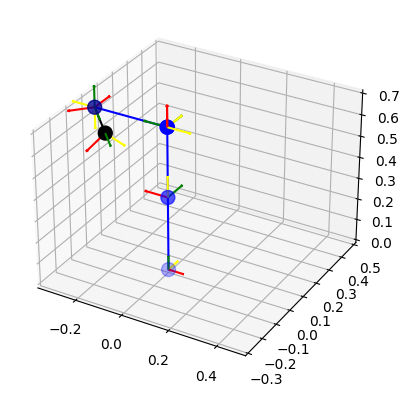

In [119]:
q = [np.pi/2, np.pi/2, -np.pi/2, 0, np.pi*3/4, np.pi/4]
plot_frame(q)

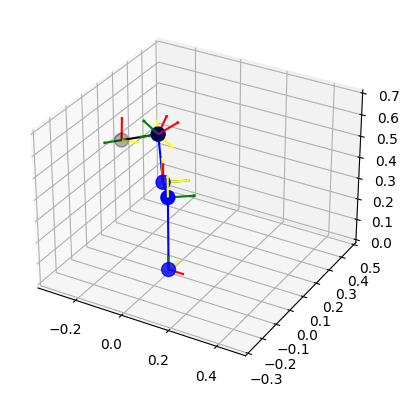

In [120]:
#plot_frame(FK(np.array([0])))
q = [np.pi/5,  -np.pi/8, np.pi/6, -np.pi/5, np.pi/3, -np.pi/6]
#q = [np.pi/6, np.pi/8, np.pi/3, np.pi/2, np.pi/3, np.pi/6]
plot_frame(q)